In [1]:
import tensorflow
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
        
    image_paths.append('C:\\Users\\herrj\\Downloads\\image0.jpg')
    return image_paths

IMAGE_PATHS = download_images()

print(IMAGE_PATHS)

['C:\\Users\\herrj\\.keras\\datasets\\image1.jpg', 'C:\\Users\\herrj\\.keras\\datasets\\image2.jpg', 'C:\\Users\\herrj\\Downloads\\image0.jpg']


In [3]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

In [4]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

# Load records

In [22]:
import cv2

raw_dataset = tf.data.TFRecordDataset('workspace/annotations/train.record')

# Create a description of the features.
feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image/width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image/encoded': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
    'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

dataset = raw_dataset.map(_parse_function)
dataset = dataset.batch(1)
dataset = dataset.repeat(1)

# Restore model

In [6]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('workspace/models/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/pipeline.config')
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('workspace/models/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8/checkpoints', 'ckpt-0')).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Weights restored!
Done! Took 7.7995216846466064 seconds


In [7]:
trainable_variables = detection_model.trainable_variables
[print(x.name) for x in trainable_variables]

RPNConv/kernel:0
RPNConv/bias:0
FirstStageBoxPredictor/ConvolutionalBoxHead_0/BoxEncodingPredictor/kernel:0
FirstStageBoxPredictor/ConvolutionalBoxHead_0/BoxEncodingPredictor/bias:0
FirstStageBoxPredictor/ConvolutionalClassHead_0/ClassPredictor/kernel:0
FirstStageBoxPredictor/ConvolutionalClassHead_0/ClassPredictor/bias:0
mask_rcnn_keras_box_predictor/mask_rcnn_box_head/BoxEncodingPredictor_dense/kernel:0
mask_rcnn_keras_box_predictor/mask_rcnn_box_head/BoxEncodingPredictor_dense/bias:0
mask_rcnn_keras_box_predictor/mask_rcnn_class_head/ClassPredictor_dense/kernel:0
mask_rcnn_keras_box_predictor/mask_rcnn_class_head/ClassPredictor_dense/bias:0
conv1_conv/kernel:0
conv1_bn/gamma:0
conv1_bn/beta:0
conv2_block1_1_conv/kernel:0
conv2_block1_1_bn/gamma:0
conv2_block1_1_bn/beta:0
conv2_block1_2_conv/kernel:0
conv2_block1_2_bn/gamma:0
conv2_block1_2_bn/beta:0
conv2_block1_0_conv/kernel:0
conv2_block1_3_conv/kernel:0
conv2_block1_0_bn/gamma:0
conv2_block1_0_bn/beta:0
conv2_block1_3_bn/gamma:0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Fine-tune

In [8]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'FirstStageBoxPredictor/ConvolutionalBoxHead_0/BoxEncodingPredictor',
  'FirstStageBoxPredictor/ConvolutionalClassHead_0/ClassPredictor']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)
    
to_fine_tune

[<tf.Variable 'FirstStageBoxPredictor/ConvolutionalBoxHead_0/BoxEncodingPredictor/kernel:0' shape=(1, 1, 512, 48) dtype=float32, numpy=
 array([[[[-0.02119465, -0.00013384, -0.01362895, ...,  0.0054606 ,
            0.02671644,  0.00731118],
          [-0.00594457, -0.00321327, -0.00686142, ...,  0.00100875,
           -0.0039757 , -0.00865853],
          [-0.00287871,  0.00048769,  0.01337595, ..., -0.00480857,
            0.0105245 , -0.00113783],
          ...,
          [-0.00859262,  0.031445  ,  0.02131697, ...,  0.00074654,
           -0.01648708, -0.00367858],
          [ 0.0012764 , -0.00686219,  0.00336014, ...,  0.00031892,
           -0.00274965,  0.00426443],
          [ 0.00964576,  0.03153174, -0.00629544, ..., -0.04302259,
            0.01087612, -0.00257357]]]], dtype=float32)>,
 <tf.Variable 'FirstStageBoxPredictor/ConvolutionalBoxHead_0/BoxEncodingPredictor/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.08101345,  0.04374497, -0.26736024, -0.24973653,  0.032093

In [4]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

#PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load('workspace/exported-models/my_model/saved_model')

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 51.82674431800842 seconds


In [101]:
batch_size = 5
learning_rate = 0.01
num_batches = 1

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shape = tf.constant([[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
        prediction_dict = model.predict(image_tensors, shape)
        losses_dict = model.loss(prediction_dict, shape)
        total_loss = 0
        #total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
        #gradients = tape.gradient(total_loss, vars_to_fine_tune)
        #optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

In [116]:
print('Start fine-tuning!', flush=True)

count = 0

for entry in dataset:
    xmins = entry['image/object/bbox/xmin']
    xmaxs = entry['image/object/bbox/xmax']
    ymins = entry['image/object/bbox/ymin']
    ymaxs = entry['image/object/bbox/ymax']
    
    coords = np.array([ymins.values, xmins.values, ymaxs.values, xmaxs.values])
    coords = coords.transpose()
    
    gt_boxes_list = [[coord[0], coord[1], coord[2], coord[3]] for coord in coords]
    gt_classes_list = entry['image/object/class/label'].values
    
    image = tf.image.decode_jpeg(entry['image/encoded'].numpy()[0])
    total_loss = train_step_fn(image[tf.newaxis, ...], [tf.convert_to_tensor(gt_boxes_list)], [[gt_classes_list]])
    
    print(total_loss)
    break

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


ValueError: in user code:

    <ipython-input-101-5e910f10fc34>:37 train_step_fn  *
        losses_dict = model.loss(prediction_dict, shape)
    C:\Users\herrj\anaconda3\lib\site-packages\object_detection\meta_architectures\faster_rcnn_meta_arch.py:2273 loss  *
        loss_dict.update(
    C:\Users\herrj\anaconda3\lib\site-packages\object_detection\meta_architectures\faster_rcnn_meta_arch.py:2464 _loss_box_classifier  *
        (batch_cls_targets_with_background, batch_cls_weights, batch_reg_targets,
    C:\Users\herrj\anaconda3\lib\site-packages\object_detection\core\target_assigner.py:512 batch_assign  *
        (cls_targets, cls_weights,
    C:\Users\herrj\anaconda3\lib\site-packages\object_detection\core\target_assigner.py:177 assign  *
        unmatched_shape_assert = shape_utils.assert_shape_equal(
    C:\Users\herrj\anaconda3\lib\site-packages\object_detection\utils\shape_utils.py:321 assert_shape_equal  *
        raise ValueError('Unequal shapes {}, {}'.format(shape_a, shape_b))

    ValueError: Unequal shapes [2], [91]


In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

Running inference for C:\Users\herrj\.keras\datasets\image1.jpg... [0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626 0.10246626
 0.10246626 0.10246626 0.10246626]
Done
Running inference for 

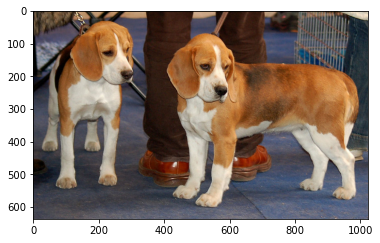

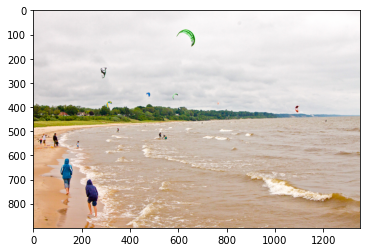

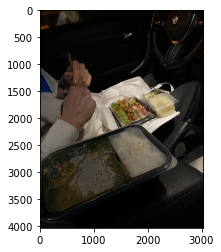

In [7]:
for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    print(detections['detection_scores'])
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    indices = [i for i, x in enumerate(detections['detection_scores']) if x >= 0.5]
    
    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2

## Transfer learning

In [24]:
model = tf.saved_model.load(PATH_TO_SAVED_MODEL)

In [29]:
print()

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_deferred_dependencies', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_map_resources', '_maybe_initialize_trackable', '_model', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_preload_simple_restoration', '_restore_from_checkpoint_position', '_self_name_based_restores', '_self_saveable_object_factories', '_self_setattr_tracking', '_self_unconditional_checkpoint_dependencies', '_self_uncondition

In [30]:
model.tensorflow_version

'2.4.0'

In [32]:
print(model.summary())

AttributeError: '_UserObject' object has no attribute 'summary'

## Tensorflow Lite

In [8]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(PATH_TO_SAVED_MODEL) # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model.
with open('../models/' + MODEL_NAME + '.tflite', 'wb') as f:
  f.write(tflite_model)